In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import GridSearchCV


In [2]:
df=pd.read_csv('clean_features.csv')

In [3]:
df.head()

,Unnamed: 0,Unnamed: 0.1,target_position,year,month,day,weekday,time_spread (t-1),dod_change (t-1),target_position (t-1),...,MID (t-20),LLS (t-20),MEH | USGC | HSK (t-20),MEH | USGC | FCC (t-20),WTI | P2 | FCC (t-20),WTI | P2 | HSK (t-20),year (t-20),month (t-20),day (t-20),weekday (t-20)
0,6,26,0.0,0.0,0.000000,0.933333,0.00,0.758130,0.209480,0.0,...,0.822816,0.581081,0.256081,0.394068,0.280245,0.222137,0.333333,0.090909,0.666667,0.25
1,7,27,1.0,0.0,0.000000,0.966667,0.25,0.758130,0.204893,0.0,...,0.774272,0.578378,0.358784,0.567797,0.440276,0.355111,0.333333,0.181818,0.666667,0.25
2,8,28,0.0,0.0,0.000000,1.000000,0.50,0.756098,0.201835,1.0,...,0.822816,0.605405,0.341216,0.546610,0.676110,0.565719,0.333333,0.363636,0.700000,0.00
3,9,29,0.0,0.0,0.090909,0.000000,0.75,0.758130,0.207951,0.0,...,0.864078,0.656757,0.408784,0.634181,0.921133,0.787855,0.333333,0.636364,0.666667,0.00
4,10,30,0.0,0.0,0.090909,0.033333,1.00,0.766260,0.217125,0.0,...,0.859223,0.656757,0.463514,0.692797,0.938744,0.810915,0.333333,0.636364,0.700000,0.25


# Correlation of input features with target value

In [4]:
#calulating Correlation of "inventory" with other features. 
corr_action=df.corrwith(df['target_position'],method='pearson').abs()
print(corr_action)

Unnamed: 0               0.034938
Unnamed: 0.1             0.034938
target_position          1.000000
year                     0.018840
month                    0.043856
                           ...   
WTI | P2 | HSK (t-20)    0.045122
year (t-20)              0.024634
month (t-20)             0.016347
day (t-20)               0.087942
weekday (t-20)           0.055592
Length: 287, dtype: float64


In [5]:
corr_action.sort_values(ascending=False).head(10)

target_position          1.000000
time_spread (t-5)        0.133369
time_spread (t-19)       0.125845
time_spread (t-4)        0.125523
time_spread (t-6)        0.123635
time_spread (t-20)       0.123492
time_spread (t-18)       0.116957
time_spread (t-7)        0.114333
target_position (t-1)    0.112927
time_spread (t-3)        0.104838
dtype: float64

In [6]:
relevant_features = corr_action[corr_action>0.05]

In [7]:
relevant_features.head()

target_position          1.000000
time_spread (t-1)        0.074681
dod_change (t-1)         0.086300
target_position (t-1)    0.112927
MEH-WTI (t-1)            0.061875
dtype: float64

In [8]:
selected_df = df[relevant_features.index]  # Only getting columns having corr> 0.1 wrt output

In [9]:
selected_df.head()

,target_position,time_spread (t-1),dod_change (t-1),target_position (t-1),MEH-WTI (t-1),LLS (t-1),weekday (t-1),time_spread (t-2),MEH-WTI (t-2),LLS (t-2),...,month (t-17),time_spread (t-18),day (t-18),time_spread (t-19),day (t-19),time_spread (t-20),MEH | USGC | HSK (t-20),MEH | USGC | FCC (t-20),day (t-20),weekday (t-20)
0,0.0,0.758130,0.209480,0.0,0.564014,0.624324,1.00,0.732724,0.640138,0.710811,...,0.636364,0.700203,0.700000,0.649390,0.666667,0.713415,0.256081,0.394068,0.666667,0.25
1,1.0,0.758130,0.204893,0.0,0.543253,0.613514,0.00,0.758130,0.564014,0.624324,...,0.636364,0.724593,0.666667,0.700203,0.700000,0.649390,0.358784,0.567797,0.666667,0.25
2,0.0,0.756098,0.201835,1.0,0.553633,0.629730,0.25,0.758130,0.543253,0.613514,...,0.000000,0.721545,0.700000,0.724593,0.666667,0.700203,0.341216,0.546610,0.700000,0.00
3,0.0,0.758130,0.207951,0.0,0.567474,0.640541,0.50,0.756098,0.553633,0.629730,...,0.000000,0.739837,0.033333,0.721545,0.700000,0.724593,0.408784,0.634181,0.666667,0.00
4,0.0,0.766260,0.217125,0.0,0.560554,0.645946,0.75,0.758130,0.567474,0.640541,...,0.000000,0.748984,0.066667,0.739837,0.033333,0.721545,0.463514,0.692797,0.700000,0.25


In [10]:
selected_df=selected_df.drop(columns=['target_position'])

# Filtering highly correlated input features

In [11]:
pearson_corr = selected_df.corr(method='pearson').abs()


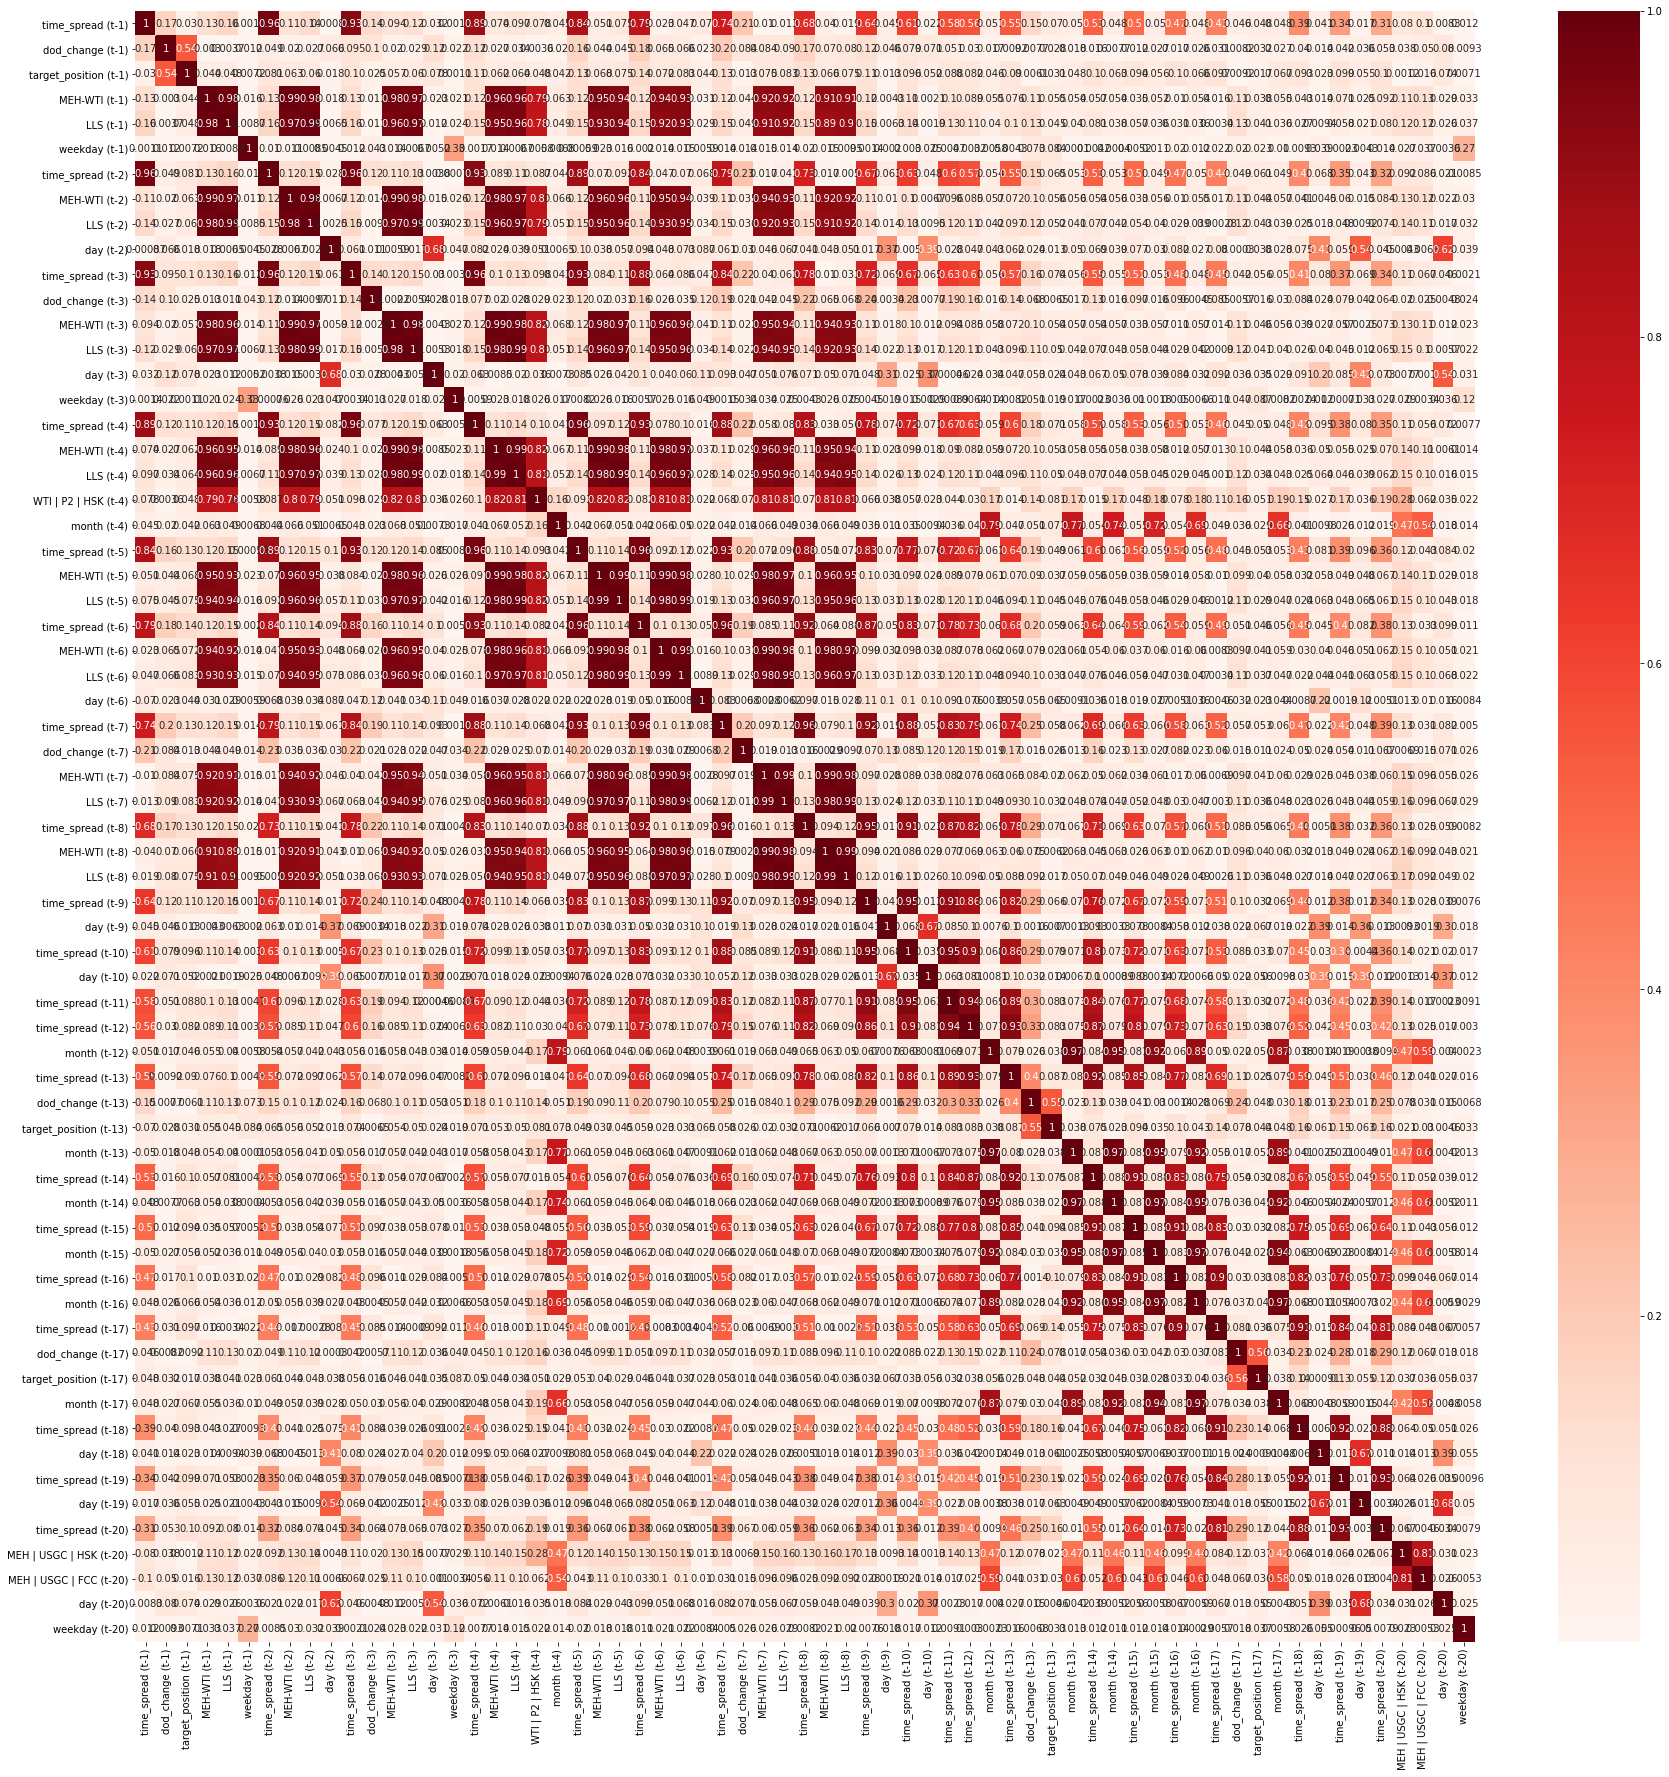

In [12]:
#Using Pearson Correlation
plt.figure(figsize=(30,30))
# cor = df.corr()
sns.heatmap(pearson_corr, annot=True, cmap=plt.cm.Reds)
plt.show()

In [13]:
columns = np.full((pearson_corr.shape[0],), True, dtype=bool)
for i in range(pearson_corr.shape[0]):
    for j in range(i+1, pearson_corr.shape[0]):
        if pearson_corr.iloc[i,j] >= 0.999:
            if columns[j]:
                columns[j] = False

In [14]:
filtered_df= selected_df.columns[columns]

In [15]:
# filtered_df_corr_output = corr_action[corr_action>0.05]

In [16]:
filtered_df

Index(['time_spread (t-1)', 'dod_change (t-1)', 'target_position (t-1)',
       'MEH-WTI (t-1)', 'LLS (t-1)', 'weekday (t-1)', 'time_spread (t-2)',
       'MEH-WTI (t-2)', 'LLS (t-2)', 'day (t-2)', 'time_spread (t-3)',
       'dod_change (t-3)', 'MEH-WTI (t-3)', 'LLS (t-3)', 'day (t-3)',
       'weekday (t-3)', 'time_spread (t-4)', 'MEH-WTI (t-4)', 'LLS (t-4)',
       'WTI | P2 | HSK (t-4)', 'month (t-4)', 'time_spread (t-5)',
       'MEH-WTI (t-5)', 'LLS (t-5)', 'time_spread (t-6)', 'MEH-WTI (t-6)',
       'LLS (t-6)', 'day (t-6)', 'time_spread (t-7)', 'dod_change (t-7)',
       'MEH-WTI (t-7)', 'LLS (t-7)', 'time_spread (t-8)', 'MEH-WTI (t-8)',
       'LLS (t-8)', 'time_spread (t-9)', 'day (t-9)', 'time_spread (t-10)',
       'day (t-10)', 'time_spread (t-11)', 'time_spread (t-12)',
       'month (t-12)', 'time_spread (t-13)', 'dod_change (t-13)',
       'target_position (t-13)', 'month (t-13)', 'time_spread (t-14)',
       'month (t-14)', 'time_spread (t-15)', 'month (t-15)',
      

In [17]:
selected_df=selected_df[selected_df.columns[selected_df.columns.isin(filtered_df)]]

In [18]:
# df=selected_df.copy()

In [19]:
selected_df.head()

,time_spread (t-1),dod_change (t-1),target_position (t-1),MEH-WTI (t-1),LLS (t-1),weekday (t-1),time_spread (t-2),MEH-WTI (t-2),LLS (t-2),day (t-2),...,month (t-17),time_spread (t-18),day (t-18),time_spread (t-19),day (t-19),time_spread (t-20),MEH | USGC | HSK (t-20),MEH | USGC | FCC (t-20),day (t-20),weekday (t-20)
0,0.758130,0.209480,0.0,0.564014,0.624324,1.00,0.732724,0.640138,0.710811,0.700000,...,0.636364,0.700203,0.700000,0.649390,0.666667,0.713415,0.256081,0.394068,0.666667,0.25
1,0.758130,0.204893,0.0,0.543253,0.613514,0.00,0.758130,0.564014,0.624324,0.833333,...,0.636364,0.724593,0.666667,0.700203,0.700000,0.649390,0.358784,0.567797,0.666667,0.25
2,0.756098,0.201835,1.0,0.553633,0.629730,0.25,0.758130,0.543253,0.613514,0.933333,...,0.000000,0.721545,0.700000,0.724593,0.666667,0.700203,0.341216,0.546610,0.700000,0.00
3,0.758130,0.207951,0.0,0.567474,0.640541,0.50,0.756098,0.553633,0.629730,0.966667,...,0.000000,0.739837,0.033333,0.721545,0.700000,0.724593,0.408784,0.634181,0.666667,0.00
4,0.766260,0.217125,0.0,0.560554,0.645946,0.75,0.758130,0.567474,0.640541,1.000000,...,0.000000,0.748984,0.066667,0.739837,0.033333,0.721545,0.463514,0.692797,0.700000,0.25


In [20]:
x_df=selected_df
y_df=df['target_position']

In [21]:
# x_train, x_test, y_train, y_test = train_test_split(x_df.values, y_df.values, test_size=0.33, random_state=42)


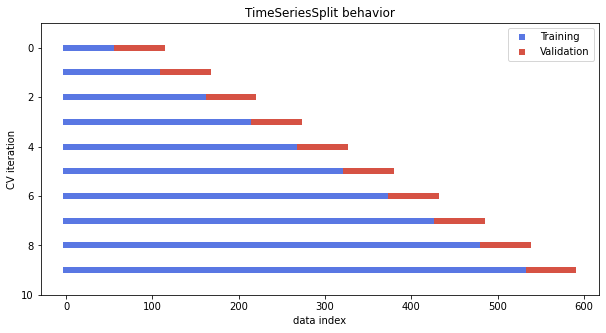

In [22]:
cv=TimeSeriesSplit(n_splits=10)

fig, ax = plt.subplots(figsize=(10, 5))
for ii, (train, test) in enumerate(cv.split(x_df, y_df)):
       
    # Plot training and test indices
    l1 = ax.scatter(train, [ii] * len(train), c=[plt.cm.coolwarm(.1)], 
                    marker='_', lw=6)
    l2 = ax.scatter(test, [ii] * len(test), c=[plt.cm.coolwarm(.9)], 
                    marker='_', lw=6)
    ax.set(ylim=[10, -1], title='TimeSeriesSplit behavior', 
           xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training', 'Validation'])

In [23]:
x_train=x_df.iloc[train,:-1].values
x_test=x_df.iloc[test,:-1].values
y_train=y_df.iloc[train].values
y_test=y_df.iloc[test].values
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((536, 64), (536,), (53, 64), (53,))

# Naive Bayes

In [24]:
sample = class_weight.compute_sample_weight('balanced', y_train)
# clf_nb = GaussianNB(priors=None, var_smoothing=0.8)
clf_nb = GaussianNB()
clf_nb.fit(x_train, y_train, sample_weight=sample)

GaussianNB()

In [36]:

y_pred_nb = clf_nb.predict(x_test)
print('probabilites on test data are:',clf_nb.predict_proba(x_test))


probabilites on test data are: [[3.57148562e-01 6.42851438e-01]
 [3.07519301e-01 6.92480699e-01]
 [5.32377155e-01 4.67622845e-01]
 [3.15340579e-01 6.84659421e-01]
 [3.51525852e-01 6.48474148e-01]
 [4.73123688e-01 5.26876312e-01]
 [3.57641425e-01 6.42358575e-01]
 [6.21106473e-01 3.78893527e-01]
 [2.85471534e-01 7.14528466e-01]
 [5.56017714e-02 9.44398229e-01]
 [4.34095664e-02 9.56590434e-01]
 [4.76341970e-02 9.52365803e-01]
 [1.18501720e-02 9.88149828e-01]
 [8.30993687e-03 9.91690063e-01]
 [1.18750801e-02 9.88124920e-01]
 [1.16697437e-02 9.88330256e-01]
 [5.02190391e-03 9.94978096e-01]
 [7.28704349e-03 9.92712957e-01]
 [2.27926772e-02 9.77207323e-01]
 [1.17488201e-02 9.88251180e-01]
 [1.71858190e-02 9.82814181e-01]
 [2.03455496e-02 9.79654450e-01]
 [8.57465425e-03 9.91425346e-01]
 [1.26970827e-02 9.87302917e-01]
 [1.03470921e-02 9.89652908e-01]
 [1.36741770e-03 9.98632582e-01]
 [1.09002227e-03 9.98909978e-01]
 [1.88562981e-03 9.98114370e-01]
 [5.04207819e-04 9.99495792e-01]
 [1.71096567

In [37]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_nb))
print ('Precision Recall and F1 score for Naive Bayes: ',precision_recall_fscore_support(y_test, y_pred_nb, average='macro'))

Accuracy: 0.5660377358490566
Precision Recall and F1 score for Naive Bayes:  (0.5343137254901961, 0.505072463768116, 0.39802469135802465, None)


# Logistic Regression

In [38]:
clf_lr = LogisticRegression(random_state=0).fit(x_test, y_test)
y_pred_lr = clf_lr.predict(x_test)
print ('probabilities are:',clf_lr.predict_proba(x_test))


probabilities are: [[0.6601352  0.3398648 ]
 [0.70699378 0.29300622]
 [0.28083251 0.71916749]
 [0.47543597 0.52456403]
 [0.56273291 0.43726709]
 [0.38409057 0.61590943]
 [0.69958198 0.30041802]
 [0.60739304 0.39260696]
 [0.52598256 0.47401744]
 [0.60239731 0.39760269]
 [0.70801255 0.29198745]
 [0.40093459 0.59906541]
 [0.42901821 0.57098179]
 [0.22850598 0.77149402]
 [0.29713736 0.70286264]
 [0.22518777 0.77481223]
 [0.37083325 0.62916675]
 [0.5708393  0.4291607 ]
 [0.22101916 0.77898084]
 [0.45849724 0.54150276]
 [0.47563435 0.52436565]
 [0.37316371 0.62683629]
 [0.4937436  0.5062564 ]
 [0.48450353 0.51549647]
 [0.32536438 0.67463562]
 [0.51530373 0.48469627]
 [0.42056053 0.57943947]
 [0.3313956  0.6686044 ]
 [0.33420678 0.66579322]
 [0.4017904  0.5982096 ]
 [0.4645669  0.5354331 ]
 [0.24807443 0.75192557]
 [0.3292172  0.6707828 ]
 [0.3298128  0.6701872 ]
 [0.43322944 0.56677056]
 [0.56480996 0.43519004]
 [0.42585424 0.57414576]
 [0.42886061 0.57113939]
 [0.37928345 0.62071655]
 [0.47

In [39]:
print(" Logistic Regression Accuracy:",metrics.accuracy_score(y_test, y_pred_lr))

print ('Precision Recall and F1 score for Logistic Regression: ',precision_recall_fscore_support(y_test, y_pred_lr, average='macro'))

 Logistic Regression Accuracy: 0.7169811320754716
Precision Recall and F1 score for Logistic Regression:  (0.7263513513513513, 0.6942028985507247, 0.695752009184845, None)


# Testing on new data

In [52]:
input_row=(x_test[10],)   # here you can give your own input array

In [49]:
input_row

(array([0.75609756, 0.20642202, 0.        , 0.5017301 , 0.58108108,
        0.5       , 0.7550813 , 0.4982699 , 0.58918919, 0.03333333,
        0.75406504, 0.20642202, 0.4982699 , 0.58918919, 0.        ,
        0.        , 0.75304878, 0.5017301 , 0.58918919, 0.48501153,
        0.        , 0.75101626, 0.50865052, 0.58918919, 0.75304878,
        0.51211073, 0.59459459, 0.86666667, 0.75      , 0.20336391,
        0.52595156, 0.6       , 0.73373984, 0.50519031, 0.5972973 ,
        0.74085366, 0.6       , 0.7347561 , 0.46666667, 0.73577236,
        0.7347561 , 0.        , 0.73272358, 0.21406728, 0.        ,
        0.        , 0.72662602, 0.        , 0.7296748 , 1.        ,
        0.72662602, 1.        , 0.72560976, 0.20030581, 1.        ,
        1.        , 0.71747967, 0.66666667, 0.72662602, 0.56666667,
        0.72256098, 0.28716216, 0.33333333, 0.53333333]),)

In [50]:
y_pred = clf_lr.predict(input_row)

In [51]:
y_pred

array([0.])

In [53]:
print ('probabilities are:',clf_lr.predict_proba(input_row))

probabilities are: [[0.70801255 0.29198745]]
